# Sentiment classifier with LSTM

In this notebook, we will implement a simple sentiment classifier using an LSTM. Follow the notebook, complete the missing part, answer the questions and apply the asked modifications.



In [2]:
from collections import defaultdict
from copy import deepcopy
import re
from typing import Callable, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from sklearn.utils import shuffle

## Downloading the dataset

Using the datasets library, we load the imdb dataset.

In [3]:
dataset = load_dataset("imdb")

Found cached dataset imdb (/Users/longvo/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 130.33it/s]


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
# We do not need the "unsupervised" split.
dataset.pop("unsupervised")

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [7]:
dataset["train"][:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

## Pretreatment **(1 point)**

Code the `pretreatment` function which clean the input text. Look at the dataset and deduce which treatment is needed.

In [8]:
import re
TAG_RE = re.compile(r'<[^>]+>')
def pretreatment(text: str) -> str:
    """Clean IMDB text entries.
    Args:
        text: an input string.
    Returns:
        The cleaned text.
    """
    text = TAG_RE.sub('', text)
    text = text.replace("\\","")
    return text

In [9]:
# This applies the pretreatment function to all
clean_dataset = dataset.map(lambda x: {"text": pretreatment(x["text"]), "label": x["label"]})

100%|██████████████████████████████████| 25000/25000 [00:00<00:00, 39626.43ex/s]


Let's see what the text now look like.

In [10]:
clean_dataset["train"]["text"][:3]

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, even then it\'s not shot 

Let's take a quick look at the labels. Notice that the labels are ordered in the training set starting by the negative reviews (0), followed by the positive ones (1). Training neural networks on this kind of configuration tends to considerably affect their performances. So the dataset will have to be shuffled.

In [14]:
clean_dataset["train"]["label"][12490:12510]

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1]

## Train/validation split **(1 point)**

In our example, we consider the test split as production data. Which means, we need to treat it as if we never see it during the training process. To experiment on the model, we need to split the training set into a training and validation set. See [here](https://huggingface.co/course/chapter5/3?fw=pt#creating-a-validation-set) on how to do so with the `Datasets` library.

Don't forget to **stratify** your split (we need to have the same proportion of class in both training and validation set).

In [15]:
clean_dataset = clean_dataset["train"].train_test_split(train_size=0.8)
clean_dataset["validation"] = clean_dataset.pop("test")
clean_dataset["test"] = dataset["test"]

In [16]:
clean_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [18]:
dataset_train, dataset_test = load_dataset("imdb", split=["train", "test"])

Found cached dataset imdb (/Users/longvo/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)
100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 104.16it/s]


In [19]:
import pandas as pd

df_dataset_train = dataset_train.to_pandas()
df_dataset_test = dataset_test.to_pandas()
df_clean_dataset_train = clean_dataset["train"].to_pandas()
df_clean_dataset_validation = clean_dataset["validation"].to_pandas()

In [20]:
# Check here that the dataset is stratified.
print("Percentage of positive reviews in original train dataset: " + str(df_dataset_train["label"].value_counts()[0] / df_dataset_train["label"].count() * 100) + '%')
print("Percentage of positive reviews in original test dataset: " + str(df_dataset_test["label"].value_counts()[0] / df_dataset_test["label"].count() * 100) + '%')
print("Percentage of positive reviews in clean train dataset: " + str(df_clean_dataset_train["label"].value_counts()[0] / df_clean_dataset_train["label"].count() * 100) + '%')
print("Percentage of positive reviews in clean test dataset: " + str(df_clean_dataset_validation["label"].value_counts()[0] / df_clean_dataset_validation["label"].count() * 100) + '%')


Percentage of positive reviews in original train dataset: 50.0%
Percentage of positive reviews in original test dataset: 50.0%
Percentage of positive reviews in clean train dataset: 49.83125%
Percentage of positive reviews in clean test dataset: 51.449999999999996%


## Categorical encoding of the vocabulary **(2 points)**

We can't feed word to a neural network. A usual solution is to turn words into categorical data by using one-hot encoding. To avoid an explosion in vocabulary size, we will only keep words which appear more than a certain amount of time.

The `Vocabulary` class below will do that for us.

In [21]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"


class Vocabulary:
    """Vocabulary manager on a collection.
    """
    def __init__(self) -> None:
        """No parameters to provide.
        """
        # Index to word mapping.
        self.index2word = [PAD_TOKEN, UNK_TOKEN]
        # Word to index mapping.
        self.word2index = {value: key for key, value in enumerate(self.index2word)}
        # Word counter.
        self.word2count = defaultdict(int)

    def add_word(self, word: str) -> None:
        """Increments the count of a word to the vocabulary.
        Args:
            word: the word.
        """
        self.word2count[word] += 1
        if not word in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.index2word.append(word)

    def add_text(self, text: str, separator: str =" ") -> None:
        """Add the words given in a text to our vocabulary.
        Args:
            text: a sequence of words separated by a given separator.
            separator: the separator used to split our text (default is " ").
        """
        for word in text.split(separator):
            self.add_word(word)

    def get_index(self, word: str) -> int:
        """Returns the index of a given word in our vocabulary.
        If the word is not in the vocabulary, returns the index for UNK_TOKEN.
        Args:
            word: a string.
        Returns:
            The corresponding index or the index for UNK_TOKEN.
        """
        return (
            self.word2index[word]
            if word in self.word2index
            else self.word2index[UNK_TOKEN]
        )

    def get_word(self, index: int) -> str:
        """Returns the word at a given index in our vocabulary.
        Args:
            index: the word position in our vocabulary.
        Returns:
            The word corresponding to the given index.
        """
        return self.index2word[index]

    def get_word_count(self, word: str) -> int:
        """Returns the number of occurences for a given word.
        Raise a 
        Args:
            The word.
        Returns:
            Its number of measured occurences.
        """
        return self.word2count[word]

    def get_vocabulary(self) -> List[str]:
        """Returns a copy of the whole vocabulary list.
        Returns:
            A list of words.
        """
        return deepcopy(self.index2word)

    def __len__(self) -> int:
        """len() function.
        Returns:
            The number of words in the vocabulary.
        """
        return len(self.index2word)

    def trim_vocabulary(self, min_occurences: int = 5) -> None:
        """Trim the vocabulary based on the number of occurrences of each words.
        Note that whole counts of deleted words are added to the UNK_TOKEN counts.
        Args:
            min_occurences: the minimum number of occurences for a word to be kept.
        """
        to_delete = {
            word for word, count in self.word2count.items() if count < min_occurences
        }
        new_word2count = defaultdict(int)
        for word, count in self.word2count.items():
            if word not in to_delete:
                new_word2count[word] = count
            else:
                new_word2count[UNK_TOKEN] += count
        new_index2word = [word for word in self.index2word if word not in to_delete]
        new_word2index = {word: index for index, word in enumerate(new_index2word)}

        self.word2count = new_word2count
        self.index2word = new_index2word
        self.word2index = new_word2index

**(1 point)** Get the vocabulary on both the training and validation set using the `Vocabulary` class. Remember, we don't use the test set here as we consider it as proxy production data. The trim it down as you see fit (around 20K words in the vocabulary is a good value).

In [22]:
vocabulary = Vocabulary()

# Your code...
for txt in clean_dataset["train"]["text"]:
  vocabulary.add_text(txt)
for txt in clean_dataset["validation"]["text"]:
  vocabulary.add_text(txt)
vocabulary.trim_vocabulary(15)
print(len(vocabulary.get_vocabulary()))

17234


In [23]:
print(vocabulary.get_vocabulary())

['<PAD>', '<UNK>', 'Do', 'not', 'bother', 'to', 'waste', 'your', 'money', 'on', 'this', 'movie.', 'even', 'go', 'into', 'car', 'and', 'think', 'that', 'you', 'might', 'see', 'movie', 'if', 'any', 'others', 'do', 'appeal', 'you.', 'If', 'must', 'a', 'weekend,', 'Batman', 'again.The', 'script', 'was', 'horrible.', 'written', 'from', 'the', 'random', 'horror', 'format.', 'place', 'in', 'confined', 'madman', 'with', 'various', 'weapons,', 'curious', 'man', 'who', 'manages', 'uncover', 'all', 'of', 'clues', 'honest', 'police', 'officers', 'cannot', 'put', 'together,', 'an', 'innocent', 'overly', 'yet', 'beautiful', 'strong', 'woman', 'whom', 'many', 'audience', 'would', 'love', 'be', 'able', 'call', 'their', 'girlfriend.', 'add', 'much', 'poorly', 'executed', 'gore,', 'what', 'hell,', "let's", 'some', 'freaks', 'there', 'for', 'little', 'plot.The', 'acting', 'horrible,', 'characters', 'unbelievable', '-', 'more', 'believable', 'than', 'can', 'someone', 'please', 'tell', 'me', 'how', 'make',

**(1 point)** Fill the encoding and decoding functions. The encoding function takes a text as input and returns a list IDs corresponding to the index of each word in the vocabulary. The decoding function reverse the process, turning a list of IDs into a text. Make sure the encoding function returns a numpy array.

In [24]:
# Encoding and decoding function

def encode_text(text: str) -> np.ndarray:
    # Your code.
    ids = []
    for word in text.split(" "):
      ids.append(vocabulary.get_index(word))
    return np.array(ids)

def decode_text(encoded_text: np.ndarray) -> str:
    # Your code.
    txt = ""
    for id in encoded_text:
      txt += " " + vocabulary.get_word(id)
    return txt


To make sure everything went well, we compare a text before and after encoding and then decoding it. You should see rare words / typos replaced by the `<UNK>` token.

In [25]:
# Apply the encoding function to the entire dataset.
encoded_dataset = clean_dataset.map(lambda x: {"text": encode_text(x["text"]), "label": x["label"]})

100%|██████████████████████████████████| 25000/25000 [00:02<00:00, 10370.33ex/s]


In [26]:
clean_dataset["train"]["text"][0], decode_text(encoded_dataset["train"]["text"][0])

('Do not bother to waste your money on this movie. Do not even go into your car and think that you might see this movie if any others do not appeal to you. If you must see a movie this weekend, go see Batman again.The script was horrible. Perfectly written from the random horror movie format. Given: a place in confined spaces, a madman with various weapons, a curious man who manages to uncover all of the clues that honest police officers cannot put together, and an innocent and overly curious, yet beautiful and strong woman with whom many in the audience would love to be able to call their girlfriend. Mix together, add much poorly executed gore, and what the hell, let\'s put some freaks in there for a little "spin" to the plot.The acting was horrible, and the characters unbelievable - Borat was more believable than this.***Spoiler***and can someone please tell me how a butcher\'s vest can make a bullet ricochet from the person after being shot without even making the person who was sho

## Batch preparation **(1 point)**

To speed up learning, and take advantage of the GPU architecture, we provide data to the model by batches. Since all line in the same batch need to have the same length, we pad lines to the maximum length of each batch.

In [27]:
def data_generator(X: np.ndarray, y: np.ndarray, batch_size: int = 32, pad_right: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Generate randomly ordered batches of data+labels.
    Args:
        X: the input data.
        y: the corresponding labels.
        batch_size: the size of each batch [32].
        pad_right: if true, the padding is done on the right [False].
    """
    
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    
    for i in range(n_batches):
        
        end = min((i+1)*batch_size, len(y))
        
        X_batch = X[i*batch_size:end]
        y_batch = y[i*batch_size:end]

        # Padding to max ength size within the batch
        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [vocabulary.get_index(PAD_TOKEN)] * (max_len - len(x))
            X_batch[j] = x+pad if pad_right else pad+x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        # Yielding results, so every time the function is called, it starts again from here.
        yield X_batch, y_batch

Let's see what the batches look like.

In [28]:
for inputs, targets in data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"]):
    print("inputs", inputs, "shape:", inputs.shape)
    print("targets", targets, "shape:", targets.shape)
    break

inputs tensor([[    0,     0,     0,  ...,   859,  2769,  6692],
        [    0,     0,     0,  ...,    40,    22, 10208],
        [    0,     0,     0,  ...,   922,  1872,     1],
        ...,
        [    0,     0,     0,  ...,     1,  7937,  5365],
        [    0,     0,     0,  ...,     1,    10,   822],
        [    0,     0,     0,  ...,  7673,    16,     1]]) shape: torch.Size([32, 1360])
targets tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 0, 1]) shape: torch.Size([32])


**(1 point)** Question: On which side should we pad the data for our use case and why?

## The model **(13 points)**

We use a simple RNN with a configurable number of layers.

In [56]:
# Before starting, let's set up the device. A GPU if available, else the CPU.
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

In [57]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

Note that we do not pass the output through a sigmoid function. This is because pyTorch implements some code optimization within the `BCEWithLogitsLoss` we'll see later.

In [58]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")

    return train_losses, valid_losses, model

We setup the model, criterion (a binary cross entropy), and the optimizer (Adam).

Note that `BCEWithLogitsLoss` use a mathematical trick to incorporate the sigmoid function in its computation. This trick makes the learning process go slightly faster and is the reason why we didn't put a sigmoid in the forward function of the model.

In [59]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

We get the 3 generators.

In [60]:
train_gen = lambda: data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"])
valid_gen = lambda: data_generator(encoded_dataset["validation"]["text"], encoded_dataset["validation"]["label"])
test_gen = lambda: data_generator(encoded_dataset["test"]["text"], encoded_dataset["test"]["label"])

And train the model.

In [61]:
train_losses, valid_losses, model = train(model, criterion, optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.6890819462537765, validation loss: 0.6836518301963806, in 0:00:27.275853
Epoch: 1, training loss: 0.6516835387945176, validation loss: 0.6414556336402893, in 0:00:28.074202
Epoch: 2, training loss: 0.6719632237553597, validation loss: 0.6684587392807007, in 0:00:28.173481
Epoch: 3, training loss: 0.6165458130836486, validation loss: 0.652989264011383, in 0:00:28.342736
Epoch: 4, training loss: 0.5700998800992966, validation loss: 0.6351718525886536, in 0:00:28.246863
Epoch: 5, training loss: 0.5690797140598297, validation loss: 0.6445515124797822, in 0:00:28.418835
Epoch: 6, training loss: 0.5051731368899346, validation loss: 0.636727741241455, in 0:00:27.667845
Epoch: 7, training loss: 0.461569049268961, validation loss: 0.6346999864578247, in 0:00:28.828091
Epoch: 8, training loss: 0.43201066881418226, validation loss: 0.694153760433197, in 0:00:27.982183
Epoch: 9, training loss: 0.40833858770132064, validation loss: 0.6097147998809814, in 0:00:28.588356
Ep

We can look at the training and validation loss.

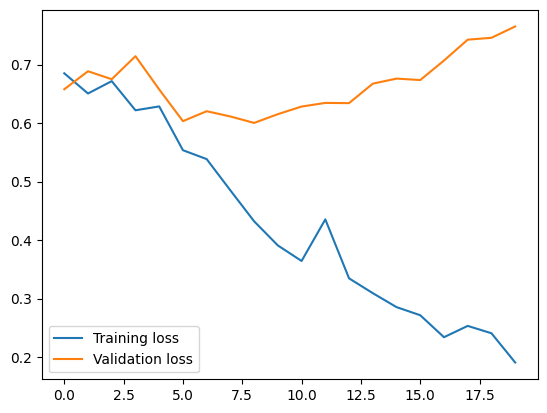

In [35]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

For the assignment, code the following.
* **(2 points)** The model validation loss should go down and then up. It means the model starts overfitting after a certain number of iterations. Modify the `train` function so it returns the model found with the best validation loss.
* **(2 points)** Add an accuracy function and report the accuracy of the training and test set.
* **(3 points)** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
* **(2 point)** Implement a function which takes any text and return the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its probability (score out of a [sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)).
    * Don't forget to make the text go through the same pretreatment and encoding you used to train your model.
* **(3 points)** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * To combine the last output of both direction, you can concatenate, add, or max-pool them. Please document your choice.
* **(1 point)** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **(Bonus)** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

In [36]:
def calculate_accuracy(outputs, labels, correct, total):
  sigmoid = nn.Sigmoid()
  treated = sigmoid(outputs)
  prob = (treated > 0.5).float()
  total += labels.size(0)
  correct += (prob == labels).sum().item()
  return correct, total

In [37]:

import copy
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)
    model_accs_train = np.zeros(n_epochs)
    model_accs_valid = np.zeros(n_epochs)
    best_valid_loss = float("inf")
    best_model = None
    for epoch in range(n_epochs):
        t0 = datetime.now()
        model.train()
        train_loss = []
        correct_train = 0
        total_train = 0
        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.
            #Calculate accuracy of the model
            correct_train, total_train = calculate_accuracy(outputs, labels, correct_train, total_train)      
        train_losses[epoch] = np.mean(train_loss)
        model_accs_train[epoch] = 100 * correct_train / total_train

        model.eval()
        valid_loss = []
        acc = None
        
        correct_valid = 0
        total_valid = 0
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss.append(loss.item())
      
            #Calculate accuracy of the model
            correct_valid, total_valid = calculate_accuracy(outputs, labels, correct_valid, total_valid)      
        valid_losses[epoch] = np.mean(valid_loss)
        model_accs_valid[epoch] = 100 * correct_valid / total_valid
        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, accuracy of training: {model_accs_train[epoch]}, validation loss: {valid_losses[epoch]}, accuracy of validation: {model_accs_valid[epoch]}, in {datetime.now() - t0}")
        if valid_losses[epoch] < best_valid_loss:
          best_model = copy.deepcopy(model)
          print(f"Model with the best validation loss: {valid_losses[epoch]}")
          best_valid_loss = valid_losses[epoch]
    return train_losses, valid_losses, best_model

In [38]:
train_losses, valid_losses, best_model = train(model, criterion, optimizer, 10, train_gen, valid_gen)

Epoch: 0, training loss: 0.20134820318222046, accuracy of training: 93.15625, validation loss: 0.7962070573568344, accuracy of validation: 72.475, in 0:00:28.897912
Model with the best validation loss: 0.7962070573568344
Epoch: 1, training loss: 0.17644074360281228, accuracy of training: 94.11875, validation loss: 0.8148620460033417, accuracy of validation: 67.6, in 0:00:28.088540
Epoch: 2, training loss: 0.19083767353743314, accuracy of training: 93.7375, validation loss: 1.1408037033081055, accuracy of validation: 60.775, in 0:00:28.222834
Epoch: 3, training loss: 0.24747685412317513, accuracy of training: 90.44375, validation loss: 0.8403235151767731, accuracy of validation: 72.825, in 0:00:28.255590
Epoch: 4, training loss: 0.14293165645375847, accuracy of training: 95.3125, validation loss: 0.8753302652835846, accuracy of validation: 72.9, in 0:00:28.730155
Epoch: 5, training loss: 0.12878360029309988, accuracy of training: 95.9875, validation loss: 0.9010809586048126, accuracy of

In [62]:
class LSTM(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
            dropout=0.2,
        )
        # A fully connected layer to project the LSTM's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = (torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device), torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device))

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.lstm(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

In [63]:
model_lstm = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_lstm.parameters())

In [ ]:
train_losses, valid_losses, model_lstm = train(model_lstm, criterion, optimizer, 20, train_gen, valid_gen)

In [65]:
def predict(sentence: str, model: nn.Module):
    treated_sentence = pretreatment(sentence)
    treated_sentence = encode_text(treated_sentence)
    treated_sentence = np.reshape(treated_sentence, (1, len(treated_sentence)))
    treated_sentence = torch.from_numpy(treated_sentence).to(device)
    output = model(treated_sentence)
    activation = nn.Sigmoid()
    activated  = activation(output)
    print("Scores out of sigmoid: " + str(activated.item()) + ", " + "Return value: " + str((activated > 0.5).float().item()))
    return activated.item(), (activated > 0.5).float().item()

In [66]:
predict("<h><\h>Hello, how are you ?", model)

Scores out of sigmoid: 0.690646767616272, Return value: 1.0


(0.690646767616272, 1.0)

In [67]:
class BiLSTM(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
            bidirectional=True
        )
        # A fully connected layer to project the LSTM's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size * 2, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = (torch.zeros(self.n_layers * 2, X.size(0), self.hidden_size).to(device), torch.zeros(self.n_layers * 2, X.size(0), self.hidden_size).to(device))
        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.lstm(out, h0)
        # Getting the last value only.
        #out = out[:, -1, :]
        out = torch.cat((out[:, -1, :self.hidden_size].squeeze(1), out[:, 0, self.hidden_size:].squeeze(1)), dim=1)
        # Linear projection.
        out = self.fc(out)

        return out

In [68]:
model_bilstm = BiLSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_bilstm.parameters())

In [69]:
train_losses, valid_losses, model_bilstm = train(model_bilstm, criterion, optimizer, 10, train_gen, valid_gen)

Epoch: 0, training loss: 0.6696731815338135, validation loss: 0.6117381188869476, in 0:02:28.430006
Epoch: 1, training loss: 0.577945800602436, validation loss: 0.5677533459663391, in 0:02:27.062164
Epoch: 2, training loss: 0.4843769963979721, validation loss: 0.6112700703144074, in 0:02:26.694177
Epoch: 3, training loss: 0.5876710138022899, validation loss: 0.664067214012146, in 0:02:24.576065
Epoch: 4, training loss: 0.4890656527876854, validation loss: 0.4796219828128815, in 0:02:23.307083
Epoch: 5, training loss: 0.34471946926414965, validation loss: 0.45020931792259217, in 0:02:22.896435
Epoch: 6, training loss: 0.27901355063170197, validation loss: 0.4379446861743927, in 0:02:24.271454
Epoch: 7, training loss: 0.23108052168786525, validation loss: 0.4084107987880707, in 0:02:25.261395
Epoch: 8, training loss: 0.19226282026246191, validation loss: 0.4089368017911911, in 0:02:24.802480
Epoch: 9, training loss: 0.15548469369113446, validation loss: 0.42738756716251375, in 0:02:23.80

In [70]:
predict("The best movie I have ever seen", best_model)

Scores out of sigmoid: 0.9938050508499146, Return value: 1.0


(0.9938050508499146, 1.0)